<a href="https://colab.research.google.com/github/elifsare/Realtime-Emotion-Recognition/blob/main/Model2v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
!ls

Mounted at /content/drive
drive  sample_data


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"elifsare","key":"65fe5c557a5858f538b76c194afd0b9a"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d msambare/fer2013

 96% 58.0M/60.3M [00:03<00:00, 25.1MB/s]
100% 60.3M/60.3M [00:03<00:00, 17.9MB/s]


In [4]:
!mkdir face_dataset
!unzip '/content/fer2013.zip' -d face_dataset

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: face_dataset/train/sad/Training_65242339.jpg  
  inflating: face_dataset/train/sad/Training_65267116.jpg  
  inflating: face_dataset/train/sad/Training_65275626.jpg  
  inflating: face_dataset/train/sad/Training_6529266.jpg  
  inflating: face_dataset/train/sad/Training_65329617.jpg  
  inflating: face_dataset/train/sad/Training_65338712.jpg  
  inflating: face_dataset/train/sad/Training_65338797.jpg  
  inflating: face_dataset/train/sad/Training_65387162.jpg  
  inflating: face_dataset/train/sad/Training_65404494.jpg  
  inflating: face_dataset/train/sad/Training_65426218.jpg  
  inflating: face_dataset/train/sad/Training_65430136.jpg  
  inflating: face_dataset/train/sad/Training_65437377.jpg  
  inflating: face_dataset/train/sad/Training_6545735.jpg  
  inflating: face_dataset/train/sad/Training_65463385.jpg  
  inflating: face_dataset/train/sad/Training_65473985.jpg  
  inflating: face_dataset/train/sad/Training_65502829.j

In [5]:
import pandas as pd                       
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf 

from keras.models import Sequential     
from keras.preprocessing import image 
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, AveragePooling2D, Activation
from keras.optimizers import SGD, Adam, RMSprop, Adamax 
from keras.utils import np_utils  
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.utils import load_img, img_to_array

import os
import seaborn as sns
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers

In [6]:
train_path = '/content/face_dataset/train'
test_path = '/content/face_dataset/test'

In [7]:
img_size = 48 #original size of the image

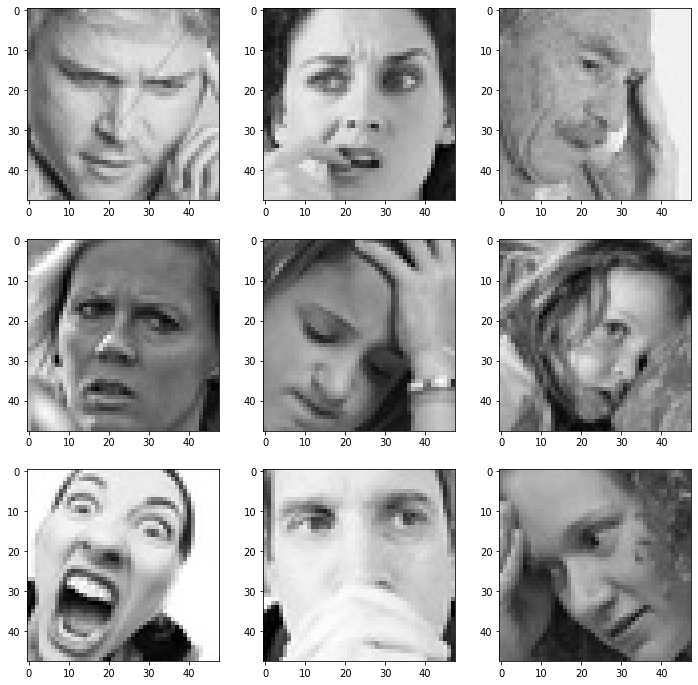

In [8]:
expression = 'fear'

plt.figure(figsize= (12,12))
folder_path = '/content/face_dataset/'
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(train_path + '/' + expression + "/" + os.listdir(train_path  + '/' + expression)[i], 
                   target_size=(48, 48)
                   )
    plt.imshow(img)   
plt.show()

In [9]:
train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [10]:
train_generator = train_datagen.flow_from_directory(directory = train_path,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_path,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                             )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [11]:
num_classes = 7 #angry, disgust, fear, happy, sad, surprise, neutral

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
    
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.summary()

model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       2

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
epochs = 60
batch_size = 64

In [13]:
# CheckPoint
root = '/content/drive/MyDrive/DeepLearningProject/EmotionDetection/'
checkPointer = ModelCheckpoint(root + 'checkPoint_model2.h5', verbose = 1, save_best_only = True)

In [14]:
# overfitting engelliyoruz
# EarlyStop
early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=20,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=15,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping, checkPointer, reduce_learningrate]

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

In [15]:
history = model.fit(x = train_generator,epochs = epochs,validation_data = validation_generator)

"""history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=batch_size,
                                epochs=epochs,
                                validation_data = test_generator,
                                validation_steps = test_generator.n//test_generator.batch_size,
                                callbacks=callbacks_list,
                                shuffle = True,
                                verbose=1
                              )"""

"""
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)
  model.save_weights("/content/drive/MyDrive/DeepLearningProject/EmotionDetection/model2.h5")

  model.save('/content/drive/MyDrive/DeepLearningProject/EmotionDetection/model2.h5')"""

Epoch 1/60
359/359 [==============================] - 32s 59ms/step - loss: 5.1594 - accuracy: 0.2153 - val_loss: 2.7172 - val_accuracy: 0.2472
Epoch 2/60
359/359 [==============================] - 18s 51ms/step - loss: 2.2613 - accuracy: 0.2853 - val_loss: 2.6501 - val_accuracy: 0.2584
Epoch 3/60
359/359 [==============================] - 20s 55ms/step - loss: 2.3502 - accuracy: 0.3812 - val_loss: 2.5186 - val_accuracy: 0.3631
Epoch 4/60
359/359 [==============================] - 18s 51ms/step - loss: 2.3400 - accuracy: 0.4400 - val_loss: 2.4195 - val_accuracy: 0.4022
Epoch 5/60
359/359 [==============================] - 18s 51ms/step - loss: 2.2638 - accuracy: 0.4705 - val_loss: 2.3498 - val_accuracy: 0.4183
Epoch 6/60
359/359 [==============================] - 19s 52ms/step - loss: 2.1860 - accuracy: 0.4875 - val_loss: 2.1219 - val_accuracy: 0.5244
Epoch 7/60
359/359 [==============================] - 19s 52ms/step - loss: 2.1184 - accuracy: 0.4990 - val_loss: 2.0120 - val_accuracy:

'\nmodel_json = model.to_json()\nwith open("model.json", "w") as json_file:\n  json_file.write(model_json)\n  model.save_weights("/content/drive/MyDrive/DeepLearningProject/EmotionDetection/model2.h5")\n\n  model.save(\'/content/drive/MyDrive/DeepLearningProject/EmotionDetection/model2.h5\')'

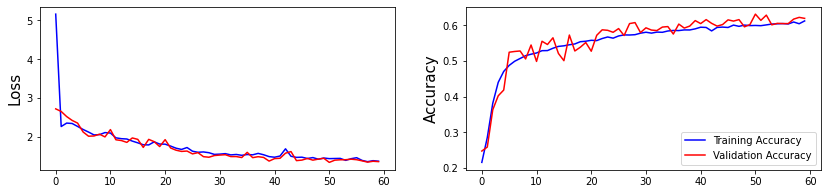

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize = (14,3))
plt.subplot(1,2,1)
#plt.suptitle('Train', fonstsize = 10)
plt.ylabel('Loss', fontsize = 15)
plt.plot(history.history['loss'], color = 'b', label = 'Training Loss')
plt.plot(history.history['val_loss'], color = 'r', label = 'Validation Loss')

plt.subplot(1,2,2)
plt.ylabel('Accuracy', fontsize = 15)
plt.plot(history.history['accuracy'], color = 'b', label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], color = 'r', label = 'Validation Accuracy')

plt.legend(loc = 'lower right')

plt.show()

In [18]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

23/23 [==============================] - 1s 21ms/step - loss: 1.3567 - accuracy: 0.6194
final train accuracy = 64.22 , validation accuracy = 61.94


In [20]:
model.save('/content/drive/MyDrive/DeepLearningProject/model2_2.h5')